# WORD GRAPH PROJECT - step 1

We will use the work done here 

https://www.kaggle.com/datasets/moxxis/harry-potter-lstm?resource=download&select=Harry_Potter_all_books_preprocessed.txt

so thank to this boy to provide all the data we searched and to prepocess even them (this should help a lot). 

We start by reading everything.

In [4]:
HP_file = open("HP_books.txt", "r")
HP_text = HP_file.read()

Now we split everything and count how many words there are. We also replace some character with a space (since we had some problem with some sentences) and we lower everything. We set | as the ending character.

In [5]:
special_char = ['.', ',', '?', '!', 'â€˜', 'â€¢', '~', '(', ')']
for s_char in special_char:
    HP_text = HP_text.replace(s_char, f" {s_char} | ")
HP_text = HP_text.lower()
HP_words = HP_text.split()
len(HP_words)

1258369

And we count the numbers of single words.

In [6]:
HP_set_words = set(HP_words)
len(HP_set_words)

23487

This is something really cool to notice. We now there are approximetely 170.000 words in the english vocabulary and this means that HP really minimize the space of the words (relatively talking).
Now we want to count the occurrencies of the single words. 

In [7]:
HP_occourrencies_dict = {}
for word in HP_words:
    if word == '':
        continue
    if word in HP_occourrencies_dict.keys():
        HP_occourrencies_dict[word] += 1
    else:
        HP_occourrencies_dict[word] = 1
HP_sorted_occourrencies_dict = dict(sorted(HP_occourrencies_dict.items(), key=lambda item: item[1], reverse=True))

In [8]:
k = 0
lim = 10
for unique_word in HP_sorted_occourrencies_dict:
    if k < lim:
        print(f"{unique_word} occourred {HP_sorted_occourrencies_dict[unique_word]}")
        k = k + 1

| occourred 85594
. occourred 67794
the occourred 51888
and occourred 27600
to occourred 26849
of occourred 21842
a occourred 21066
he occourred 20428
harry occourred 16745
was occourred 15644


Let's implement a class for the graph.

In [33]:
import random
import copy

class WordGraph:
    def __init__(self, text): # we assume the text is already prepocessed
        self.text = text
        self.words = self.text.split()
        self.unique_word = set(self.words)
        self.words_dict = {u_word : {} for u_word in self.unique_word}
        self.compute_graph()
    
    def compute_graph(self):
        for predecessor, successor in zip(self.words[:-1], self.words[1:]):
            if predecessor == '' or successor == '':
                continue
            if successor not in self.words_dict[predecessor].keys():
                self.words_dict[predecessor][successor] = 1
            else:
                self.words_dict[predecessor][successor] += 1
    
    def print_graph(self):
        for words in self.words_dict:
            print(f"{words} ")
            for word in self.words_dict[words]:
                print(f" |->{word} : {self.words_dict[words][word] }")
            print(" ")
    
    def print_word(self, key_word):
        key_word = key_word.lower()
        print(f"{key_word} ")
        try:
            w_dict = self.words_dict[key_word]
        except:
            print(" |->Word not found")
            return
        for word in w_dict:
            print(f" |->{word} : {self.words_dict[key_word][word] }")
    
    def generate_from_word(self, key_word, max_deep = 15):
        key_word = key_word.lower()
        if max_deep == 0 or key_word == '|':
            print()
            return
        print(key_word, end=' ')
        try:
            w_dict = self.words_dict[key_word]
        except:
            print("Word not found")
            return 
        cumulative_space = {}
        c = 0 
        for word in w_dict:
            c = c + self.words_dict[key_word][word]
            cumulative_space[c] = word
        index = random.randint(0, c)
        for ind in cumulative_space.keys(): # we could optimize this with a binary search. now it's not needed.
            if index < ind:
                self.generate_from_word(cumulative_space[ind], max_deep - 1)
                return 
    
    def networkx_format(self):
        results = copy.deepcopy(self.words_dict)
        for word in results:
            for w in results[word]:
                results[word][w] = {"weight" : results[word][w]}
        return results

In [35]:
HP_wg = WordGraph(HP_text)

We implement also a function called "generate from word" that simply, given a word, create a cumulative probabilistic function and generate from it the next word. the cumulative function just use the sum of the occurrencies in order. sampled by it we take the correspective word: if it finds an end character (or goes too deep in the recursion) it terminates. 

In [43]:
HP_wg.generate_from_word('.', max_deep=25)

. 


We can clearly see that this method is not really efficient (we knew it but it was funnny to try to implement this). So now we will try to use word2vec and maybe will try to use even a transformer. This means we go to the second part! Before that we try to implement a graph representation of all of this!

In [37]:
import networkx as nx
nx_wordgraph = nx.from_dict_of_dicts(HP_wg.networkx_format())

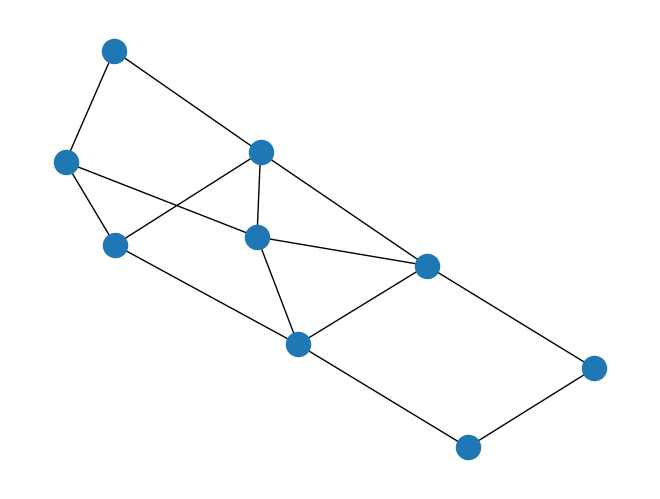

In [44]:
text = 'ciao mi chiamo mario e mi chiamo giovanni sono amico di giovanni e di mario ciao'
wg = WordGraph(text)
nx_wg = nx.from_dict_of_dicts(wg.networkx_format())
nx.draw(nx_wg)

Everything cool but the graph is too big... mmm... not a problem, we are gonna resolve this. 

We could start by reducing the graph dimension for example. But, how do we start? 

The first idea (that could be a little bad) is just to delete everything that is not "important" (we are gonna define this importance term here) and then compute the graph. I think that our first approach on this should be using the number of occurrencies as the importance factor. let's say we want only 100 nodes (we should have approximately 30k nodes at the beginning): we keep only the 100 words that occours the most. 

This means that theoretically is possible we have some recursive connection (for example: the initial sentence was *i was wondering if i was brave enough* and then, after we compute the 100 words with most occurrencies we left with only *i i enough* and this leads to i having a recursion edge on it).